In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [5]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import pickle
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms
from sklearn import preprocessing

import src.utils.setup_figures as figures
# import src.utils.basic as utils
from src.utils.glm_hmm_utils import global_fit, session_wise_fit_cv


import numpy.random as npr
# npr.seed(0)

### Load Configs

In [6]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)
compiled_dir = Path(dir_config.data.compiled)

### Utils functions

In [15]:
def process_session_data(data):
    data['target'] = (2*data.target - 1).astype(int)
    data['choice'] = data['choice'].astype(int)
    data['signed_coherence'] = data['coherence'] * data['target']
    data['previous_target'] = data.target.shift(1)
    data.loc[data.index[0], 'previous_target'] = data.target.values[0]
    data['previous_choice'] = data.choice.shift(1)
    data.loc[data.index[0], 'previous_choice'] = data.choice.values[0]
    
    first_valid = np.where(data.outcome >= 0)[0][0]
    indices_to_change_previous_choice = data[data.previous_choice == -1].index
        
    for i in indices_to_change_previous_choice:
        if i < first_valid:
            data.loc[data.index[i], 'previous_choice'] = np.random.choice([-1, 1])
            data.loc[data.index[i], 'previous_target'] = np.random.choice([-1, 1])
        else:
            j=0
            while i - j >= 0 and data.at[data.index[i - j], 'previous_choice'] == -1:
                j+=1
            data.loc[data.index[i], 'previous_choice'] = data.loc[data.index[i-j], 'previous_choice']
            data.loc[data.index[i], 'previous_target'] = data.loc[data.index[i-j], 'previous_target']  
    
    
    data['previous_choice'].replace(0, -1, inplace=True) # remap previous choice to -1, 1
    
    return data

def extract_previous_data(trial_data):
    # npr.seed()
    prev_choice = np.hstack([trial_data.choice[0] , trial_data.choice[:-1]])  # 0:awayRF, 1:toRF of previous valid trial
    prev_target = np.hstack([trial_data.target[0] , trial_data.target[:-1]]) * 2 - 1 # -1:awayRF, 1:toRF of previous valid trial 
    prev_outcome = np.hstack([trial_data.outcome[0] , trial_data.outcome[:-1]])
    prev_valid_idx = np.where(prev_outcome >= 0)[0]
    prev_invalid_idx = np.where(prev_outcome == -1)[0]

    for i in prev_invalid_idx:
        if i < prev_valid_idx[0]: #randomly sample if no previous valid trials
            prev_choice[i] = np.random.binomial(1,0.5)
            prev_target[i] = np.random.binomial(1,0.5) * 2 - 1
        else:
            last_valid =  np.where(prev_valid_idx<i)[0][-1]
            prev_choice[i] = prev_choice[prev_valid_idx[last_valid]]
            prev_target[i] = prev_target[prev_valid_idx[last_valid]]
            
    prev_choice = (prev_choice * 2) - 1 # -1:awayRF, 1:toRF of previous valid trial
    return prev_choice.astype(int), prev_target.astype(int)

def prepare_input_data(data, input_dim):
    X = np.ones((1, data.shape[0], input_dim))
    
    current_stimulus = data.coherence * (2*data.target-1)
    current_stimulus = current_stimulus / 100
    
    X[0,:,0] = current_stimulus
    X[0,:,2], X[0,:,3] = extract_previous_data(data)
    return list(X)
    

### Load Data

In [36]:
session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"), index_col=None)

#### Create design matrix (input, observation, mask)

In [17]:
n_states = 2            # number of discrete states
obs_dim = 1             # number of observed dimensions: choice
num_categories = 2      # number of categories for output (toRF/awayRF)
input_dim = 4           # input dimensions: current signed coherence, 1(bias), previous choice(toRF/awayRF), previous target side(toRF/awayRF)

#### Data preparation

In [18]:
inputs_session_wise = []
choices_session_wise = []
invalid_idx_session_wise = []
masks_session_wise = []

for session_id in (session_metadata['session_id']):
    session_data = pd.read_csv(Path(compiled_dir, session_id, f"{session_id}_trial.csv"), index_col=None).fillna(-1)
    gp_trial_data = session_data[session_data.task_type == 1].reset_index()

    inputs_session_wise += prepare_input_data(gp_trial_data, input_dim)
    choices = gp_trial_data.choice.values.reshape(-1,1).astype('int')

    masks_session_wise.append(np.array(choices >= 0))
    invalid_idx = np.where(choices == -1)[0].reshape(-1,1)
    invalid_idx_session_wise.append(invalid_idx)

    # for training, replace -1 with random sample from 0,1
    choices[choices == -1] = npr.choice(1,invalid_idx.shape[0])
    choices_session_wise.append(choices)
    
inputs_aggregated, choices_aggregated, masks_aggregated = [], [], []
inputs_aggregated.append(np.vstack(inputs_session_wise))
choices_aggregated.append(np.vstack(choices_session_wise))
masks_aggregated.append(np.vstack(masks_session_wise))

# scaling signed coherence
inputs_aggregated[0][:,0] = preprocessing.scale(inputs_aggregated[0][:, 0], axis=0)
for idx_session in range(len(session_metadata)):
    inputs_session_wise[idx_session][:,0] = preprocessing.scale(inputs_session_wise[idx_session][:, 0], axis=0) # normalize signed coherence


### Fit data

In [127]:
models_glm_hmm, fit_lls_glm_hmm = global_fit(observations=choices_aggregated, inputs=inputs_aggregated, masks=masks_aggregated, n_iters=2000, n_initializations=20)

Fitting GLM globally...


  0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 2 states...


Converged to LP: -22541.4:  42%|████▏     | 833/2000 [04:54<06:52,  2.83it/s]


Fitting 3 states...


Converged to LP: -22519.6:  86%|████████▌ | 1716/2000 [09:24<01:33,  3.04it/s]


Fitting 4 states...


LP: -22539.3: 100%|█████████▉| 1999/2000 [20:12<00:00,  4.54it/s]

Fitting 5 states...


LP: -21252.9: 100%|██████████| 2000/2000 [17:03<00:00,  1.95it/s]


In [144]:
global_fits = {
    'models': models_glm_hmm,
    'fits_lls_glm_hmm': fit_lls_glm_hmm,
}

with open(Path(processed_dir, 'models_glm_hmm_global.pkl'), 'wb') as f:
    pickle.dump(global_fits, f)

In [128]:
# get best model of 20 initializations for each state
init_params = {
    'glm_weights': {},
    'transition_matrices': {}
}
for n_states in np.arange(2,6):
    best_idx = np.argmax([np.max(arr) for arr in fit_lls_glm_hmm[n_states]])
    init_params['glm_weights'][n_states] = models_glm_hmm[n_states][best_idx].observations.params
    init_params['transition_matrices'][n_states] = models_glm_hmm[n_states][best_idx].transitions.params

In [141]:
# fit session-wise with 5 fold cross-validation
models_session_state_fold, session_train_ll, session_test_ll = session_wise_fit_cv(observations=choices_session_wise, inputs=inputs_session_wise, masks=masks_session_wise,
                                                                    n_sessions=len(session_metadata), init_params=init_params, n_iters=2000)

Fitting session 0...
Fitting 2 states...


Converged to LP: -378.5:   1%|          | 13/2000 [00:00<00:24, 80.03it/s]


Fitting 3 states...


Converged to LP: -397.2:   3%|▎         | 60/2000 [00:00<00:19, 97.36it/s] 


Fitting 4 states...


Converged to LP: -428.5:   3%|▎         | 67/2000 [00:00<00:22, 86.38it/s]


Fitting 5 states...


LP: -349.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 1...
Fitting 2 states...


Converged to LP: -347.9:   3%|▎         | 66/2000 [00:00<00:14, 134.25it/s]


Fitting 3 states...


LP: -431.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -435.2:   0%|          | 9/2000 [00:00<00:25, 79.06it/s]]

Fitting 5 states...


LP: -369.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 2...
Fitting 2 states...


LP: -395.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


Converged to LP: -382.2:   2%|▏         | 37/2000 [00:00<00:19, 98.22it/s]


Fitting 4 states...


LP: -445.4:   0%|          | 5/2000 [00:00<00:40, 49.44it/s]

Fitting 5 states...


LP: -378.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 3...
Fitting 2 states...
Fitting 3 states...


LP: -404.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


  0%|          | 0/2000 [00:00<?, ?it/s]00<?, ?it/s]

Fitting 5 states...


LP: -429.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 4...
Fitting 2 states...


LP: -469.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -485.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -524.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -370.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 5...
Fitting 2 states...
Fitting 3 states...


LP: -411.6:   0%|          | 7/2000 [00:00<00:30, 66.11it/s]]

Fitting 4 states...


Converged to LP: -409.6:   1%|          | 23/2000 [00:00<00:26, 75.32it/s]


Fitting 5 states...


LP: -466.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 6...
Fitting 2 states...
Fitting 3 states...


LP: -503.1:   0%|          | 7/2000 [00:00<00:29, 66.77it/s]

Fitting 4 states...


LP: -569.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -376.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 7...
Fitting 2 states...


Converged to LP: -367.4:   0%|          | 8/2000 [00:00<00:16, 122.84it/s]]

LP: -411.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


Converged to LP: -391.6:   1%|          | 12/2000 [00:00<00:27, 72.93it/s]


Fitting 4 states...


LP: -456.3:   0%|          | 5/2000 [00:00<00:41, 47.62it/s]

Fitting 5 states...


LP: -371.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 8...
Fitting 2 states...
Fitting 3 states...


LP: -384.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -412.5:   0%|          | 6/2000 [00:00<00:33, 59.88it/s]

Fitting 5 states...


LP: -460.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 9...
Fitting 2 states...


Converged to LP: -446.3:   1%|▏         | 28/2000 [00:00<00:15, 126.89it/s]


Fitting 3 states...


LP: -521.2:   0%|          | 6/2000 [00:00<00:33, 58.84it/s]

Fitting 4 states...


LP: -565.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -393.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 10...
Fitting 2 states...
Fitting 3 states...


LP: -444.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -495.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


Converged to LP: -399.1:   1%|          | 16/2000 [00:00<00:17, 114.75it/s]


Fitting session 11...
Fitting 2 states...


LP: -427.2:   0%|          | 0/2000 [00:00<?, ?it/s].88it/s]

Fitting 3 states...


LP: -476.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


Converged to LP: -456.2:   4%|▍         | 80/2000 [00:00<00:19, 98.53it/s] 


Fitting 5 states...


LP: -412.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 12...
Fitting 2 states...
Fitting 3 states...


LP: -457.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -485.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


Converged to LP: -442.7:  14%|█▍        | 283/2000 [00:03<00:21, 79.02it/s]


Fitting session 13...
Fitting 2 states...


LP: -442.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -459.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -494.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -383.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 14...
Fitting 2 states...


LP: -414.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -446.9:   0%|          | 8/2000 [00:00<00:25, 77.72it/s]

Fitting 4 states...


LP: -468.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -387.2:   1%|          | 11/2000 [00:00<00:19, 102.48it/s]

Fitting session 15...
Fitting 2 states...


LP: -405.4:   0%|          | 8/2000 [00:00<00:27, 72.60it/s]

Fitting 3 states...


LP: -437.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -477.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -386.8:   1%|          | 11/2000 [00:00<00:18, 108.13it/s]

Fitting session 16...
Fitting 2 states...


LP: -414.0:   0%|          | 10/2000 [00:00<00:20, 95.21it/s]]

Fitting 3 states...


LP: -476.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -473.1:   0%|          | 7/2000 [00:00<00:32, 60.74it/s]

Fitting 5 states...


Converged to LP: -499.0:  15%|█▍        | 294/2000 [00:03<00:19, 86.02it/s] 


Fitting session 17...
Fitting 2 states...


LP: -368.6:   0%|          | 9/2000 [00:00<00:23, 84.95it/s]]]

Fitting 3 states...


LP: -401.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -460.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -447.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 18...
Fitting 2 states...


LP: -471.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -489.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -517.8:   0%|          | 5/2000 [00:00<00:43, 45.64it/s]

Fitting 5 states...


LP: -405.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 19...
Fitting 2 states...
Fitting 3 states...


LP: -449.4:   0%|          | 7/2000 [00:00<00:30, 65.35it/s]

Fitting 4 states...


LP: -477.2:   0%|          | 6/2000 [00:00<00:36, 54.75it/s]

Fitting 5 states...


LP: -485.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 20...
Fitting 2 states...


Converged to LP: -481.6:   4%|▍         | 76/2000 [00:00<00:15, 121.94it/s]


Fitting 3 states...


LP: -551.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -591.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -457.2:   1%|          | 13/2000 [00:00<00:15, 125.78it/s]

Fitting session 21...
Fitting 2 states...


LP: -486.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -517.6:   0%|          | 7/2000 [00:00<00:28, 69.24it/s]

Fitting 4 states...


LP: -526.6:   0%|          | 7/2000 [00:00<00:31, 62.50it/s]

Fitting 5 states...


LP: -454.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 22...
Fitting 2 states...


LP: -508.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


Converged to LP: -492.1:   2%|▏         | 32/2000 [00:00<00:25, 75.85it/s]


Fitting 4 states...


LP: -546.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -425.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 23...
Fitting 2 states...


LP: -463.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -493.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -513.1:   0%|          | 5/2000 [00:00<00:40, 49.68it/s]

Fitting 5 states...


LP: -490.7:   1%|          | 12/2000 [00:00<00:17, 115.23it/s]

Fitting session 24...
Fitting 2 states...


LP: -518.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -543.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -575.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -284.7:   1%|          | 15/2000 [00:00<00:13, 142.64it/s]

Fitting session 25...
Fitting 2 states...


LP: -304.3:   0%|          | 8/2000 [00:00<00:25, 78.63it/s]

Fitting 3 states...


LP: -343.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -359.9:   0%|          | 0/2000 [00:00<?, ?it/s].21it/s]

Fitting 5 states...


LP: -496.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 26...
Fitting 2 states...


Converged to LP: -456.5:   1%|          | 20/2000 [00:00<00:20, 97.09it/s]


Fitting 3 states...


Converged to LP: -484.4:   3%|▎         | 54/2000 [00:00<00:20, 92.69it/s]


Fitting 4 states...


Converged to LP: -504.5:   3%|▎         | 68/2000 [00:00<00:22, 86.34it/s]


Fitting 5 states...


LP: -457.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 27...
Fitting 2 states...
Fitting 3 states...


LP: -503.3:   0%|          | 0/2000 [00:00<?, ?it/s].17it/s]

Fitting 4 states...


LP: -530.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -391.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 28...
Fitting 2 states...
Fitting 3 states...


LP: -469.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -484.5:   0%|          | 5/2000 [00:00<00:41, 47.83it/s]

Fitting 5 states...


LP: -477.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 29...
Fitting 2 states...


LP: -476.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -521.3:   0%|          | 7/2000 [00:00<00:29, 66.54it/s]

Fitting 4 states...


LP: -521.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -467.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 30...
Fitting 2 states...


LP: -489.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -482.2:   0%|          | 6/2000 [00:00<00:36, 54.53it/s]

Fitting 4 states...


LP: -555.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -415.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 31...
Fitting 2 states...
Fitting 3 states...


LP: -473.3:   0%|          | 8/2000 [00:00<00:26, 73.87it/s]

Fitting 4 states...


LP: -507.1:   0%|          | 5/2000 [00:00<00:47, 41.79it/s]

Fitting 5 states...


Converged to LP: -453.0:   1%|          | 12/2000 [00:00<00:14, 136.89it/s]


Fitting session 32...
Fitting 2 states...
Fitting 3 states...


LP: -522.3:   0%|          | 0/2000 [00:00<?, ?it/s]3.72it/s]

Fitting 4 states...


LP: -562.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


Converged to LP: -543.1:  35%|███▍      | 691/2000 [00:07<00:13, 97.97it/s] 


Fitting session 33...
Fitting 2 states...


LP: -488.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -499.4:   0%|          | 9/2000 [00:00<00:22, 88.25it/s]

Fitting 4 states...


LP: -532.8:   0%|          | 5/2000 [00:00<00:43, 45.91it/s]

Fitting 5 states...


LP: -476.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 34...
Fitting 2 states...
Fitting 3 states...


LP: -501.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -541.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -501.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 35...
Fitting 2 states...
Fitting 3 states...


LP: -562.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


Converged to LP: -521.3:   2%|▏         | 35/2000 [00:00<00:23, 85.29it/s]


Fitting 5 states...


LP: -486.6:   1%|          | 11/2000 [00:00<00:18, 108.83it/s]

Fitting session 36...
Fitting 2 states...


LP: -510.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -541.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -589.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -356.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 37...
Fitting 2 states...
Fitting 3 states...


LP: -378.4:   0%|          | 6/2000 [00:00<00:33, 58.67it/s]

Fitting 4 states...


Converged to LP: -376.3:   2%|▏         | 36/2000 [00:00<00:29, 67.57it/s]


Fitting 5 states...


LP: -502.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 38...
Fitting 2 states...
Fitting 3 states...


LP: -552.4:   0%|          | 0/2000 [00:00<?, ?it/s].16it/s]

Fitting 4 states...


LP: -555.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


  0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 39...
Fitting 2 states...


  0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -556.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -580.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -449.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 40...
Fitting 2 states...


LP: -466.6:   0%|          | 8/2000 [00:00<00:26, 75.75it/s]

Fitting 3 states...


LP: -496.6:   0%|          | 6/2000 [00:00<00:37, 53.65it/s]

Fitting 4 states...


LP: -527.9:   0%|          | 6/2000 [00:00<00:37, 53.79it/s]

Fitting 5 states...


LP: -429.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 41...
Fitting 2 states...


LP: -457.1:   0%|          | 10/2000 [00:00<00:21, 92.79it/s]

Fitting 3 states...


LP: -499.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -530.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -459.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 42...
Fitting 2 states...


LP: -440.3:   0%|          | 8/2000 [00:00<00:27, 71.43it/s]

Fitting 3 states...


LP: -498.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -493.7:   0%|          | 6/2000 [00:00<00:38, 52.27it/s]

Fitting 5 states...


LP: -426.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 43...
Fitting 2 states...
Fitting 3 states...


LP: -508.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -516.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -365.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 44...
Fitting 2 states...


LP: -374.1:   0%|          | 7/2000 [00:00<00:29, 66.97it/s]

Fitting 3 states...


LP: -427.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -466.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -475.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 45...
Fitting 2 states...
Fitting 3 states...


Converged to LP: -441.8:   1%|          | 11/2000 [00:00<00:27, 71.32it/s]


Fitting 4 states...


Converged to LP: -462.9:   3%|▎         | 52/2000 [00:00<00:21, 90.12it/s]


Fitting 5 states...


Converged to LP: -484.9:   9%|▊         | 172/2000 [00:02<00:21, 83.24it/s] 


In [145]:
session_wise_fits = {
    'models': models_session_state_fold,
    'train_ll': session_train_ll,
    'test_ll': session_test_ll
}

with open(Path(processed_dir, 'models_glm_hmm_session_wise.pkl'), 'wb') as f:
    pickle.dump(session_wise_fits, f)
    

In [7]:
import pickle

with open(Path(processed_dir, 'models_glm_hmm_session_wise.pkl'), 'rb') as f:
    session_wise_fits = pickle.load(f)



#### Get best model

In [12]:
session_wise_fits['test_ll'].shape




(46, 4, 5)

In [16]:
test_LL_session_wise_across_fold = np.mean(session_wise_fits['test_ll'], axis=2)
test_LL_state_wise_across_fold_and_session = np.mean(test_LL_session_wise_across_fold, axis=0)

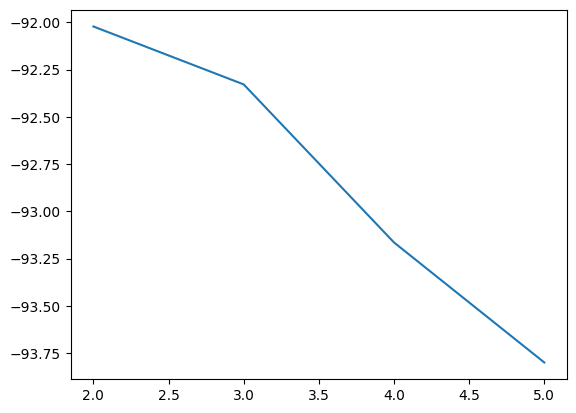

In [18]:
plt.plot([2,3,4,5], test_LL_state_wise_across_fold_and_session)

In [34]:

def plot_model_fit(model, num_states, input_dim, session_id):
    
    fix, axs = plt.subplots(1, 1, figsize=(4, 4))

    cols = ['#ff7f00', '#4daf4a', '#377eb8']
    recovered_weights = -model.observations.params
    for k in range(num_states):
        axs.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                    lw=1.5,  label = '', linestyle = '-')
    axs.set_ylabel("GLM weight", fontsize=15)
    axs.set_xlabel("covariate", fontsize=15)
    axs.set_xticks([0, 1, 2, 3], ['stimulus', 'previous_choice,', 'previous_stimulus', 'bias'], fontsize=12, rotation=10)
    axs.axhline(y=0, color="k", alpha=0.5, ls="--")
    axs.legend(fontsize=12);
    axs.set_title(f"Weight recovery: Session {session_id}", fontsize=15)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

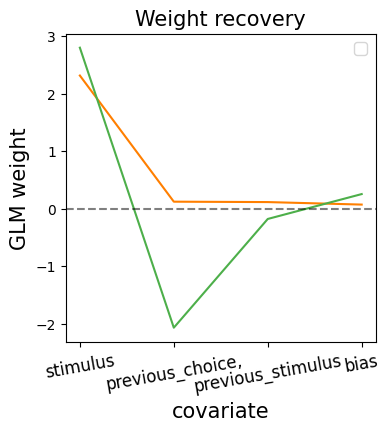

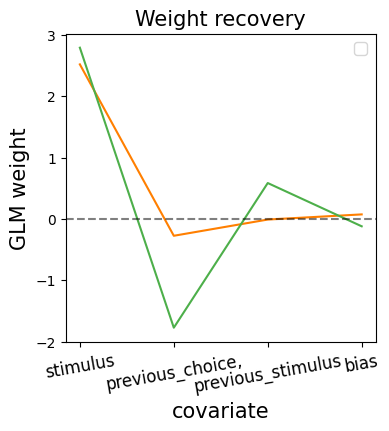

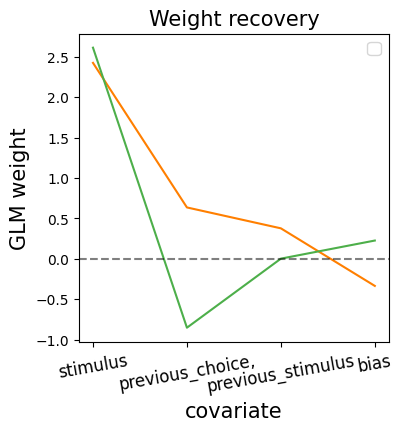

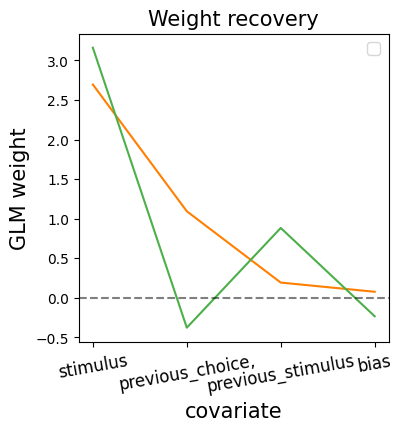

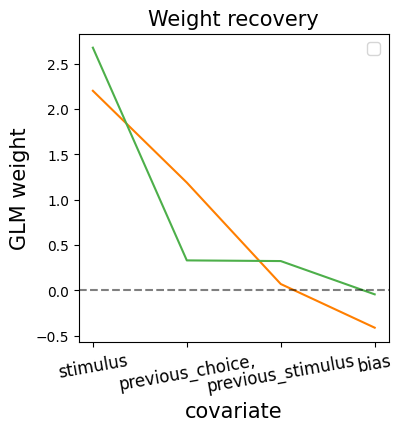

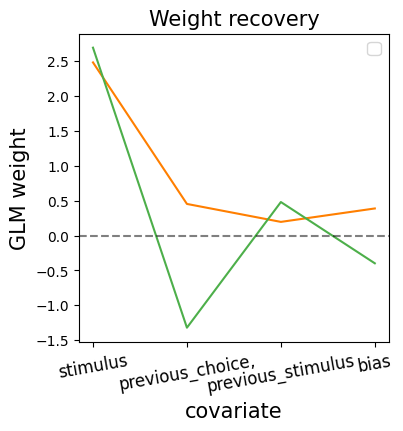

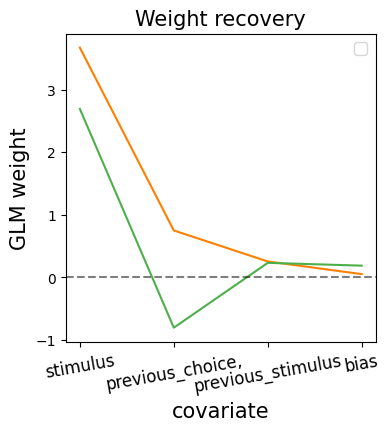

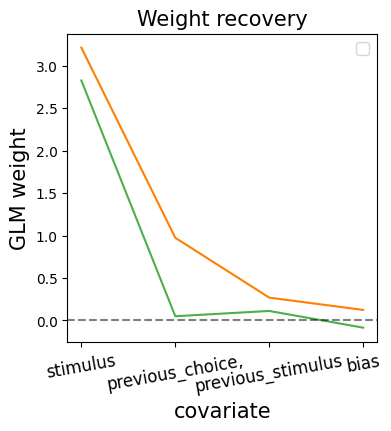

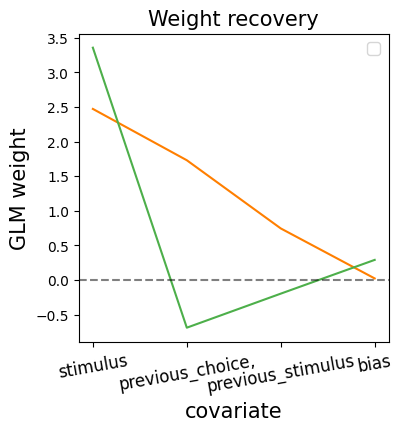

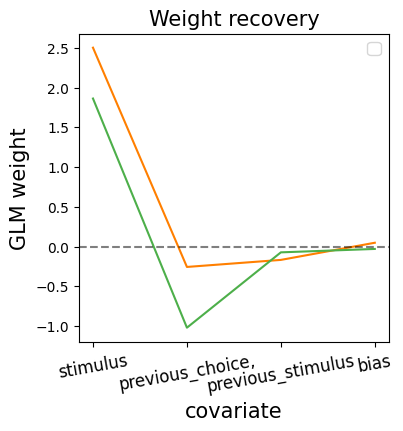

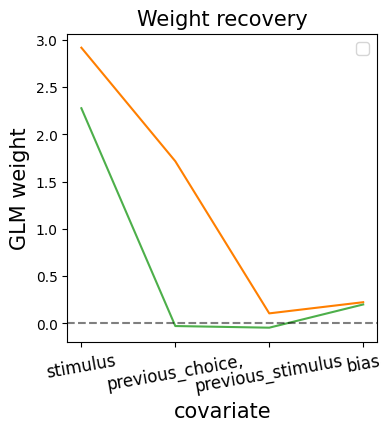

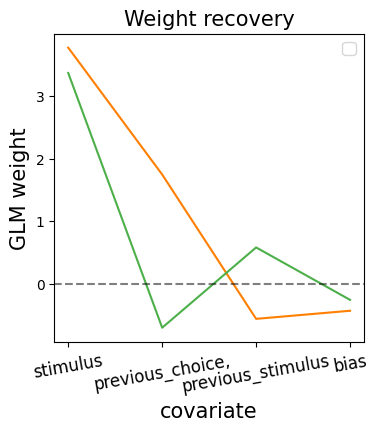

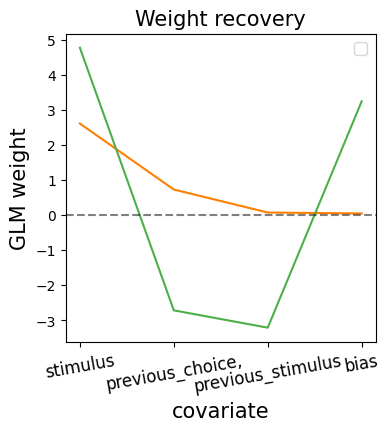

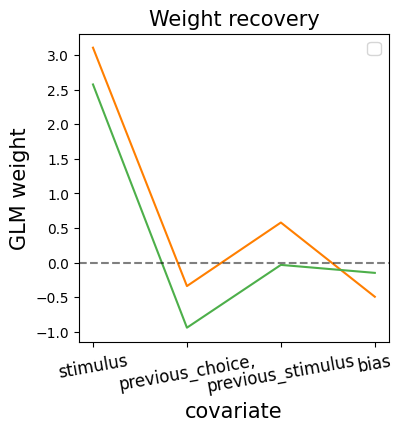

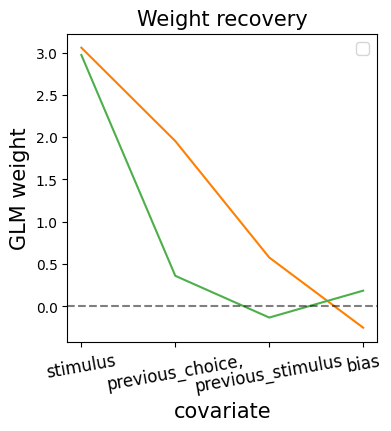

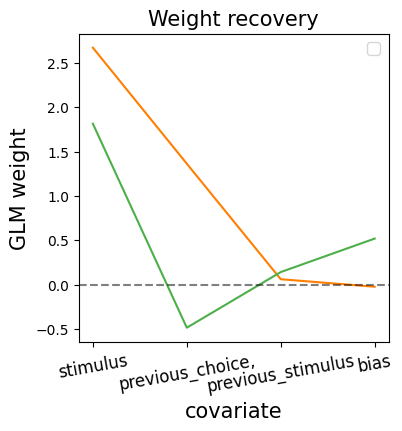

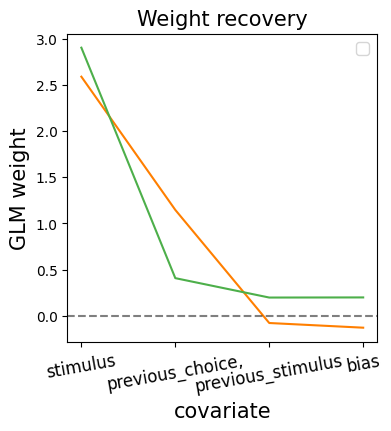

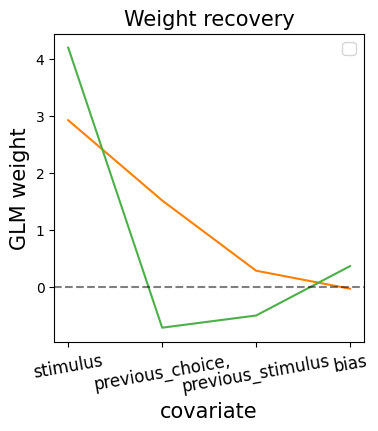

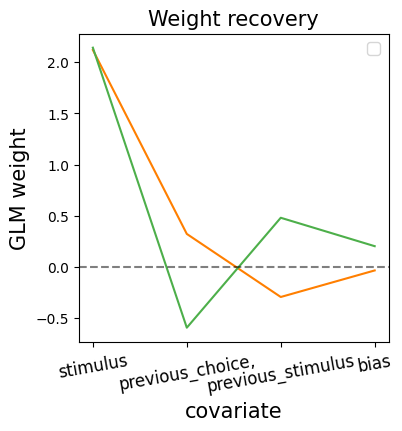

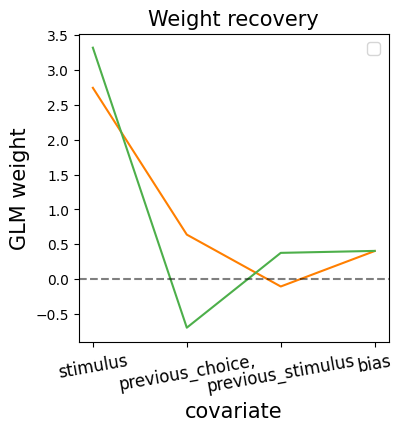

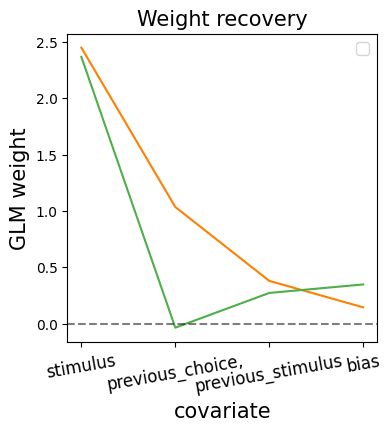

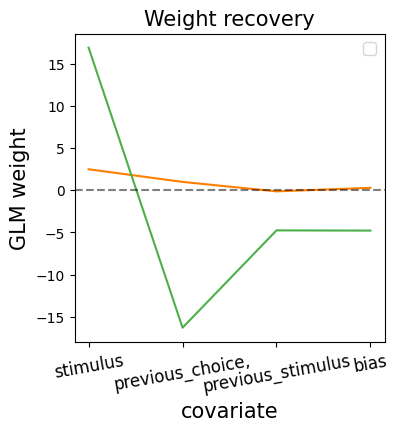

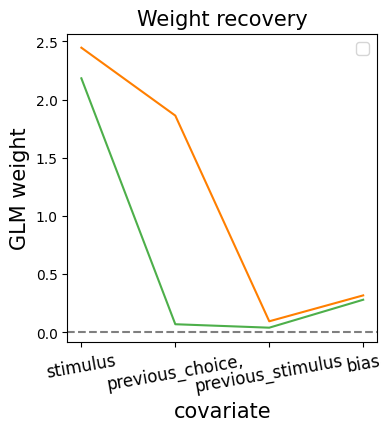

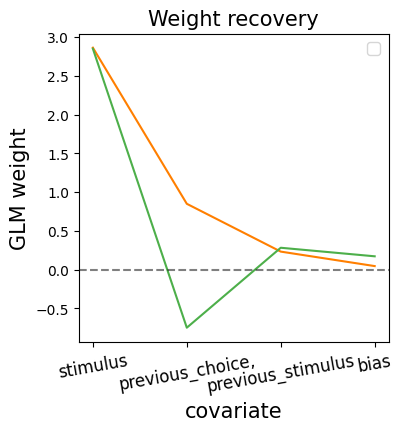

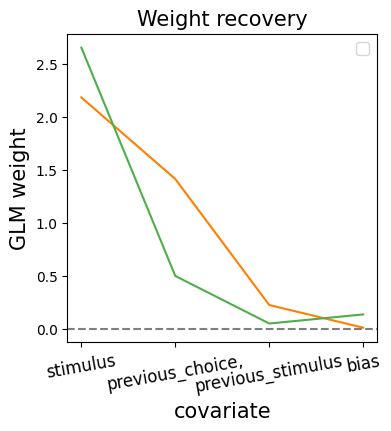

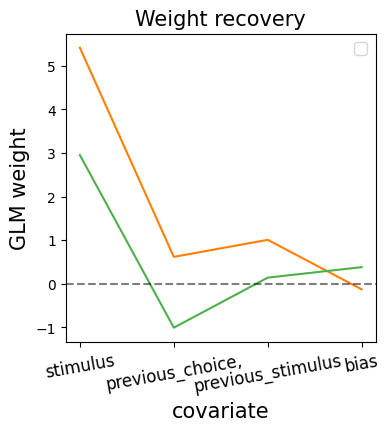

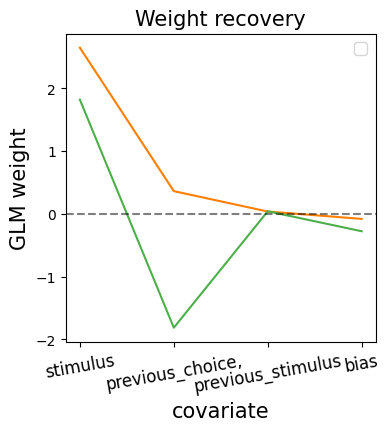

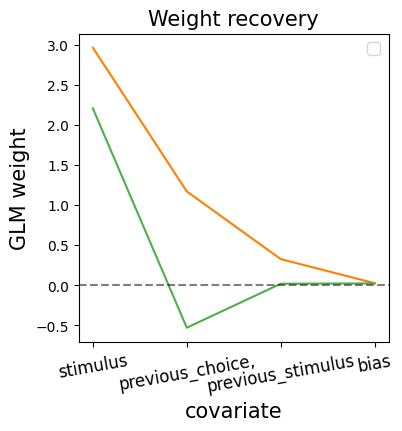

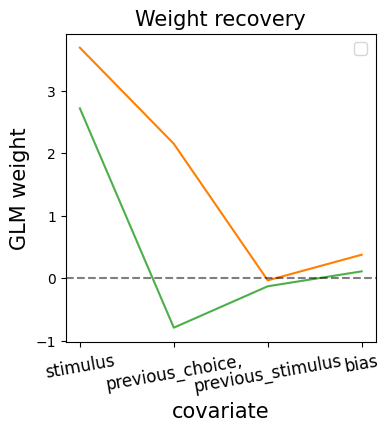

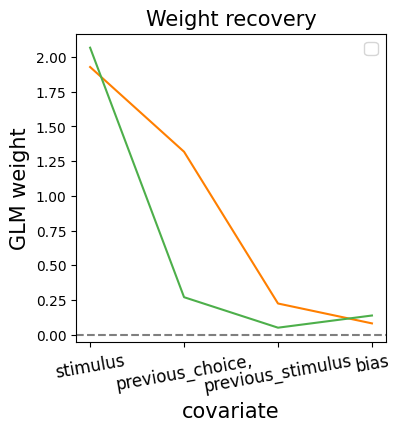

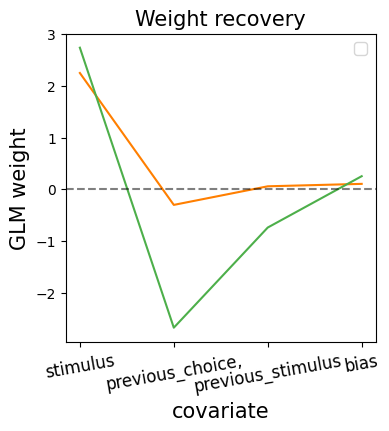

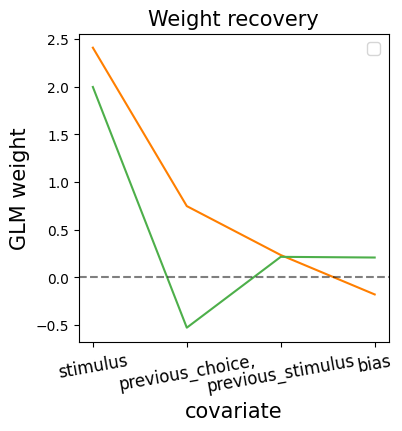

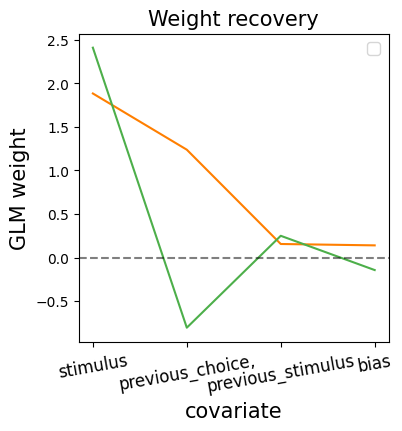

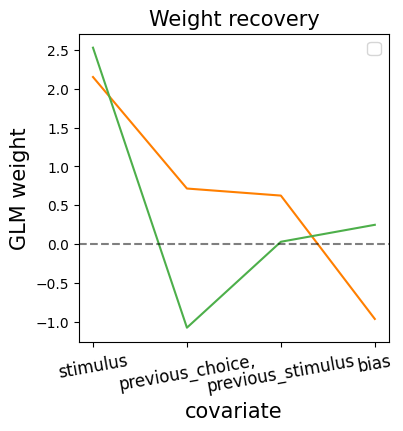

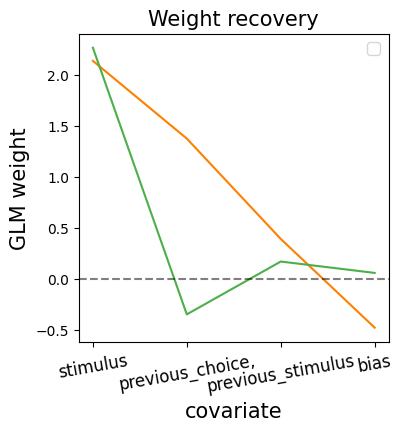

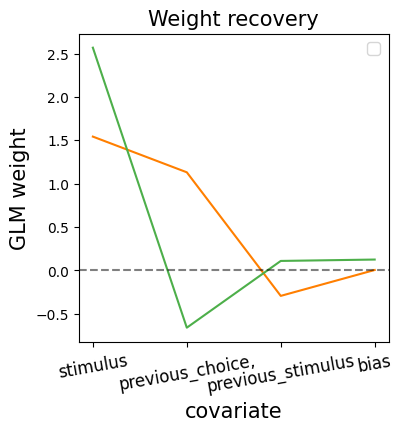

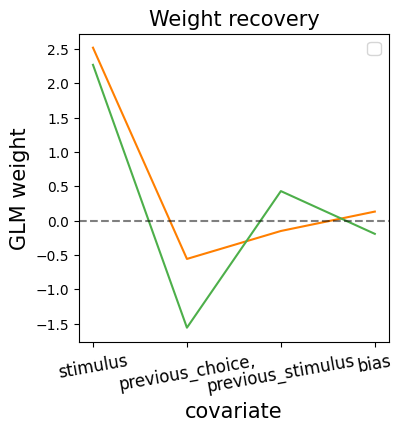

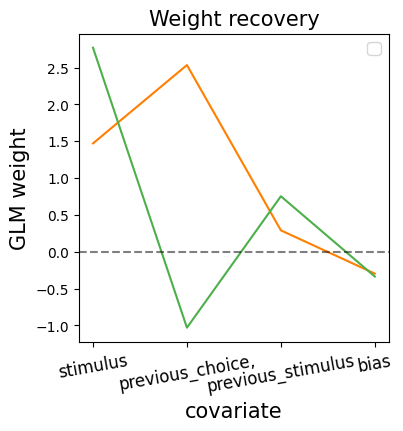

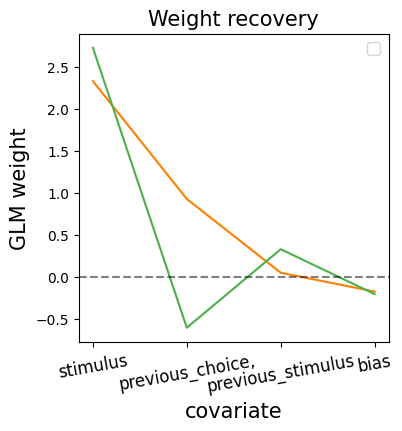

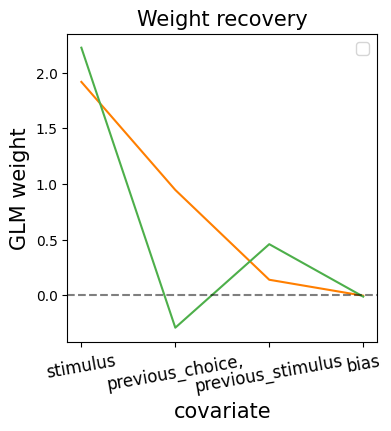

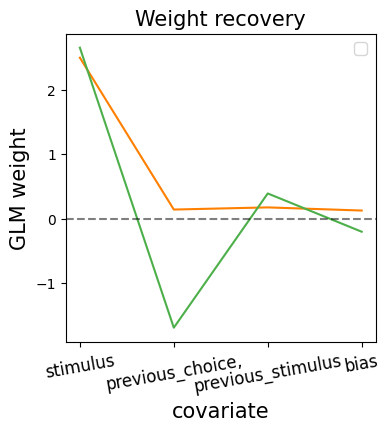

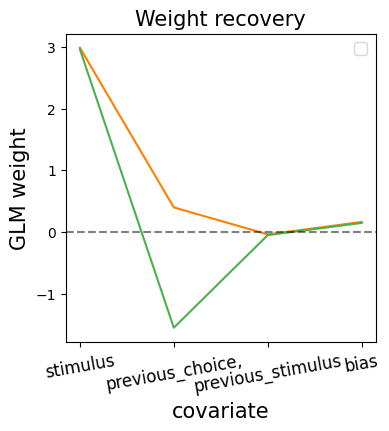

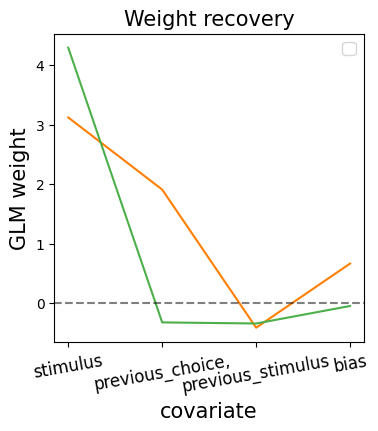

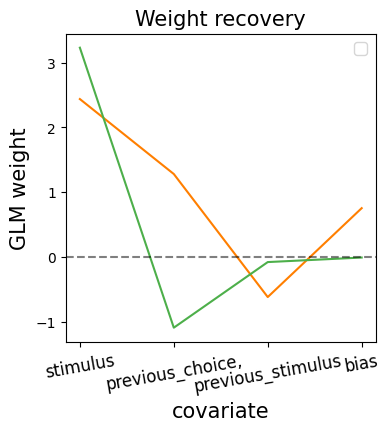

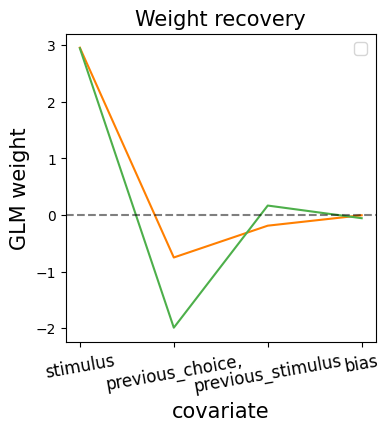

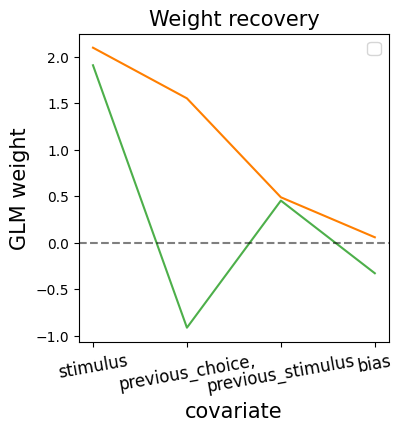

In [35]:
for n_states in [2]:
    for session_id in range(46):
        model = session_wise_fits['models'][session_id][n_states][0]
        plot_model_fit(model, n_states, input_dim=4, session_id=session_id)
        

In [42]:
toRF_sessions = np.where(session_metadata.prior_direction == 'toRF')[0]
awayRF_sessions = np.where(session_metadata.prior_direction == 'awayRF')[0]

toRF_sessions, awayRF_sessions

(array([ 2,  3,  4,  6,  7,  8, 10, 12, 14, 15, 16, 17, 20, 21, 22, 24, 27,
        28, 29, 32, 34, 35, 37, 38, 39, 42, 45]),
 array([ 0,  1,  5,  9, 11, 13, 18, 19, 23, 25, 26, 30, 31, 33, 36, 40, 41,
        43, 44]))

(-5.0, 5.0)

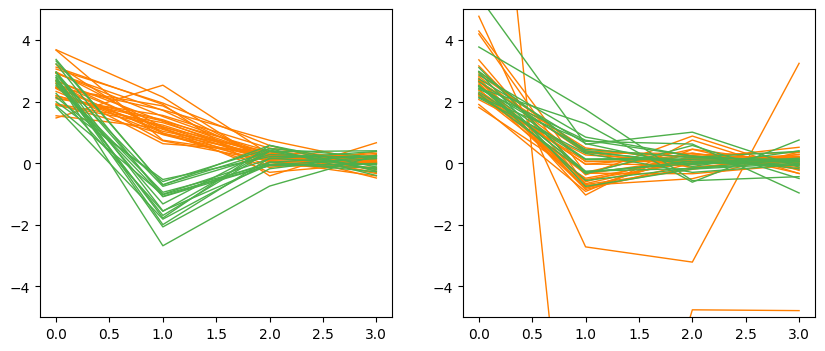

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.ravel()

cols = ['#ff7f00', '#4daf4a', '#377eb8']
for n_states in [2]:
    for session_id in toRF_sessions:
        model = session_wise_fits['models'][session_id][n_states][0]
        recovered_weights = -model.observations.params
        axs[0].plot(range(4), recovered_weights[0][0], color=cols[0],
                    lw=1,  label = '', linestyle = '-')
        axs[1].plot(range(4), recovered_weights[1][0], color=cols[0],
                    lw=1,  label = '', linestyle = '-')
    for session_id in awayRF_sessions:
        model = session_wise_fits['models'][session_id][n_states][0]
        recovered_weights = -model.observations.params
        axs[1].plot(range(4), recovered_weights[0][0], color=cols[1],
                    lw=1,  label = '', linestyle = '-')
        axs[0].plot(range(4), recovered_weights[1][0], color=cols[1],
                    lw=1,  label = '', linestyle = '-')
            
axs[0].set_ylim([-5 , 5])
axs[1].set_ylim([-5 , 5])

In [ ]:
for n_states in [2]:
    for session_id in toRF_sessions:
        model = session_wise_fits['models'][session_id][n_states][0]
        recovered_weights = -model.observations.params
        axs[0].plot(range(4), recovered_weights[0][0], color=cols[0],
                    lw=1.5,  label = '', linestyle = '-')
        axs[2].plot(range(4), recovered_weights[1][0], color=cols[1],
                    lw=1.5,  label = '', linestyle = '-')
    for session_id in awayRF_sessions:
        model = session_wise_fits['models'][session_id][n_states][0]
        recovered_weights = -model.observations.params
        axs[1].plot(range(4), recovered_weights[0][0], color=cols[0],
                    lw=1.5,  label = '', linestyle = '-')
        axs[3].plot(range(4), recovered_weights[1][0], color=cols[1],
                    lw=1.5,  label = '', linestyle = '-')


In [ ]:
stim_aligned_ts = {}
def extract_timeseries(session_id, trials_id)
    stim_aligned_ts['']
    